In [256]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from typing import Sequence, Callable, NewType
import random
from numpy.random import default_rng
from collections import defaultdict
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [175]:
def adf(apid1: int, apid2: int, funcs) -> float:
    p1 = funcs[apid1]
    p2 = funcs[apid2]

    a = len(p1.difference(p2)) + len(p2.difference(p1))
    return np.sqrt(a)

MalwareClass = NewType('MalwareClass', [int, int])

def lcl(a:int, labels) -> MalwareClass:
    return [[0, 1], [1, 0]][labels[a]]


def create_voting_net(gamma: float, 
                      apns: Sequence[int], 
                      distance: Callable[[int,int], float], 
                      classifier: Callable[[int], MalwareClass ]):
    net = dict()

    for a in apns:
        insert = True
        for n in net.keys():
            if distance(a, n) <= gamma:
                insert = False
                net[n] = list(np.add(net[n],classifier(a)))
                break  # does it always belong to only one point? probably
        if insert:
            net[a] = classifier(a)

    return net


def create_aggregating_net(gamma: float, apns: Sequence[int], distance: Callable[[int, int], float]):
    net = dict()

    for a in apns:
        insert = True
        for n in net.keys():
            if distance(a, n) <= gamma:
                insert = False
                net[n].append(a)
                break  
        if insert:
            net[a] = list()

    return net

def merge_voting_nets_new(nets, distance, gamma):
    apns = []
    for net in nets:
        apns += list(net.keys())

    nn = create_aggregating_net(gamma=gamma,
                                apns=apns,
                                distance=distance)
    
    # transfer the "votes" from original networks to just created new anchors
    targ = dict()
    for k, v in nn.items():
        for net in nets:
            if k in net:
                targ[k] = net.get(k)
                break

        for el in v:
            for net in nets:
                if el in net:
                    targ[k] = list(np.add(targ[k], net[el]))
                    break

    return targ

def merge_voting_nets(nets, distance, gamma):
    apns = []
    for net in nets:
        apns += list(net.keys())

    nn = create_aggregating_net(gamma=gamma,
                                apns=apns,
                                distance=distance)
    targ = defaultdict(lambda: [0, 0])

    for k, v in nn.items():
        for net in nets:
            targ[k] = [i+j for i, j in zip(targ[k], net.get(k, [0, 0]))]

        for el in v:
            for net in nets:
                targ[k] = [i+j for i, j in zip(targ[k], net.get(el, [0, 0]))]
            #targ[k] = [i+j for i,j in zip(targ[k], convert_to_voting([el], labels))]

    return dict(targ)

### Lambda overhead


In [261]:
from functools import partial

def afunc(x,y,z):
    return x*y+2**z

lfunc = lambda x,y: afunc(x,y, 5)
pfunc = partial(afunc, z=5)

In [287]:
a = np.random.randint(0, 100, size=500)
b = np.random.randint(0, 100, size=500)


In [296]:
%timeit res = [afunc(x,y,5) for (x,y) in zip(a,b)]

438 µs ± 7.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [297]:
%timeit res = [lfunc(x,y) for (x,y) in zip(a,b)]

462 µs ± 6.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [298]:
%timeit res = [pfunc(x,y) for (x,y) in zip(a,b)]

502 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Data preparation

In [57]:
def join_tables(funcs, labels):
    lapns = labels.set_index('apn')
    gj = lapns.join(funcs)
    gj.dropna(inplace=True)
    gj['mal'] = gj.malware_label.astype(int)
    return gj.drop('malware_label', axis=1)

In [4]:
labels = pd.read_csv('data/labels_encoded.csv')

v = pd.read_csv('data/functions_encoded.csv')
funcs = v.groupby(by='apn')['nf'].apply(set)


In [77]:
geef = join_tables(funcs=funcs, labels=labels)

afs = geef['nf'].to_numpy()
lbs = geef['mal'].to_numpy()

In [31]:
def get_part_indexes(dfs, num_parts, size):
    rn = default_rng(42)
    permuted_indices = rn.permutation(dfs.size)
    return [permuted_indices[i:i+size] for i in range(0, size*num_parts, size)]


In [173]:
%timeit mvo = merge_voting_nets(nets=vnets, distance=lambda x,y: adf(x,y, afs), gamma=8)

8.85 s ± 74.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [176]:
%timeit mvo2 = merge_voting_nets_new(nets=vnets, distance=lambda x,y: adf(x,y, afs), gamma=8)

9.51 s ± 707 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [231]:
def compare_networks(n1, n2):
    for k, el in n1.items():
        if el!=n2[k]:
            print(f"difference found {k=} {n1[k]}, {n2[k]}")

In [209]:
def countin_decorator(func):
    def inner(*args, **kwargs):
        inner.calls +=1
        return func(*args, **kwargs)
    inner.calls = 0
    return inner

In [214]:
@countin_decorator
def mydistance(x,y,funcs):
    return adf(x,y,funcs)

### Complexity
Number of distance calculations to merge a network
1. in one shot
1. in a hierarchical manner

In [254]:
def compare_mergings(vnets, gamma):
    mydistance.calls = 0
    mvo2 = merge_voting_nets_new(nets=vnets, distance=lambda x,y: mydistance(x,y, afs), gamma=gamma)
    one_shot_operations = mydistance.calls
    
    mydistance.calls =0
    nets = vnets.copy()
    while len(nets) > 1:
            b = zip(nets[::2], nets[1::2])
            nets = [merge_voting_nets_new(nets=bi, distance=lambda x,y: mydistance(x,y, afs), gamma=gamma) for bi in b]
    stepwise_operations = mydistance.calls
    
    return one_shot_operations, stepwise_operations,  len(mvo2.keys()), len(nets[0].keys())

In [257]:
num_parts = 8
part_size = 100
parts = get_part_indexes(afs, num_parts, part_size)

res = dict()

for gamma in tqdm([0, 2, 4, 8, 16]):
    vnets = [create_voting_net(gamma=gamma, apns=part, 
                               distance=lambda x,y: adf(x,y, afs), 
                               classifier=lambda x: lcl(x, labs)) for part in parts]
    res[gamma] = compare_mergings(vnets, gamma)


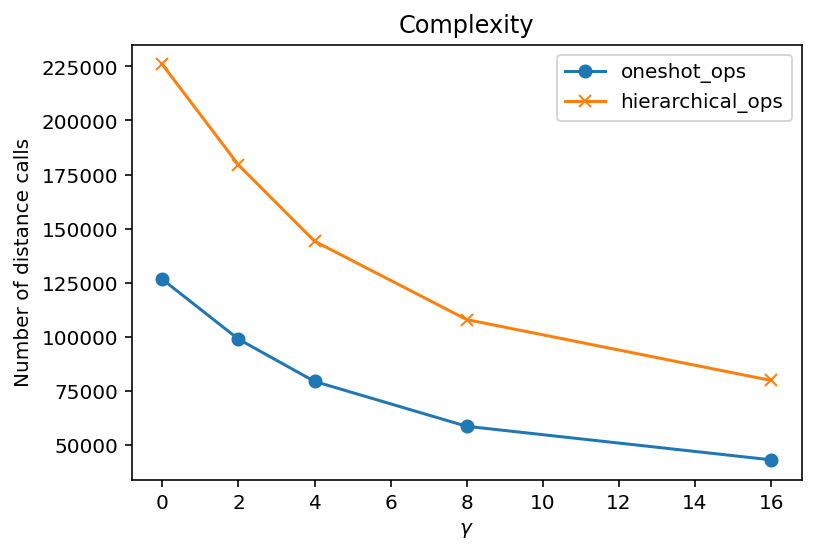

In [259]:
rdf = pd.DataFrame.from_dict(res, orient='index', columns=['one_shot_ops', 'hierarchical_ops', 'one_shot_anchors', 'hierarchical_anchors'])

plt.plot(rdf.one_shot_ops,'-o', label='oneshot_ops')
plt.plot(rdf.hierarchical_ops,'-x', label='hierarchical_ops')
plt.legend();
plt.xlabel(r"$\gamma$")
plt.ylabel("Number of distance calls");
plt.title('Complexity');

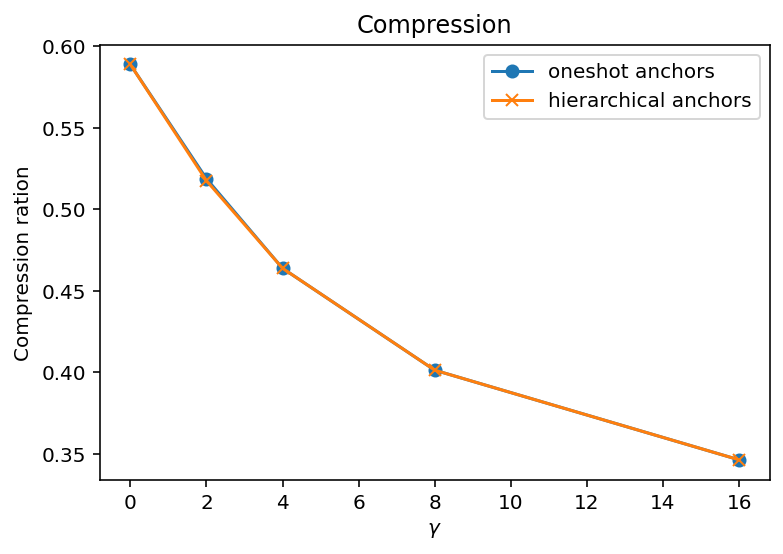

In [260]:
plt.plot(rdf.one_shot_anchors/(num_parts*part_size),'-o', label='oneshot anchors')
plt.plot(rdf.hierarchical_anchors/(num_parts*part_size),'-x', label='hierarchical anchors')
plt.legend();
plt.xlabel(r"$\gamma$")
plt.ylabel("Compression ration");
plt.title('Compression');

### Looking into operations of hierarchical merging

In [299]:
gamma = 8

In [300]:
num_parts = 8
part_size = 100
parts = get_part_indexes(afs, num_parts, part_size)


vnets = [create_voting_net(gamma=gamma, apns=part, distance=lambda x,y: adf(x,y, afs), classifier=lambda x: lcl(x, labs)) for part in parts]

In [324]:
res = dict()
mydistance.calls =0
nets = vnets.copy()
while len(nets) > 1:
    b = zip(nets[::2], nets[1::2])
    nets = [merge_voting_nets_new(nets=bi, distance=lambda x,y: mydistance(x,y, afs), gamma=gamma) for bi in b]
    res[len(nets)] = mydistance.calls

In [325]:
print(mydistance.calls)

108005


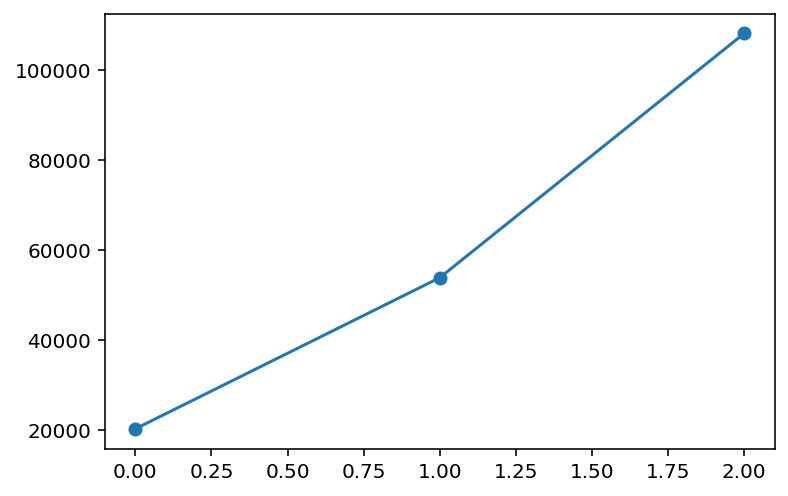

In [326]:
plt.plot( res.values(), '-o');


In [327]:
## baseline
mydistance.calls = 0
ons = merge_voting_nets_new(nets=vnets, distance=lambda x,y: mydistance(x,y, afs), gamma=gamma)
print(mydistance.calls)

58714


In [329]:
mydistance.calls = 0
vnets = [create_voting_net(gamma=gamma, apns=part, distance=lambda x,y: mydistance(x,y, afs), classifier=lambda x: lcl(x, labs)) for part in parts]
print(mydistance.calls)

13607


In [334]:
#compression of merged network comparing not to size of input data but size of the input networks
len(ons.keys())/sum([len(v.keys()) for v in vnets]), len(ons.keys())/(num_parts*part_size)

(0.7447795823665894, 0.40125)

## Complexity of network calculation

Hypothesis: 

network calculation O(size) + O(compresion*size^2)

In [349]:
from scipy.optimize import curve_fit

In [364]:
num_parts = 1
gamma = 8
res = dict()
for part_size in tqdm([100, 200, 300, 400, 500, 800, 1000]):
    part = get_part_indexes(afs, num_parts, part_size)[0]
    mydistance.calls = 0
    vn = create_voting_net(gamma=gamma, apns=part, distance=lambda x,y: mydistance(x,y, afs), 
                            classifier=lambda x: lcl(x, labs))
    res[part_size] = [mydistance.calls, len(vn.keys())]


In [366]:
cpx = pd.DataFrame.from_dict(res, orient='index', columns=['ops', 'net_size'])
#cpx.to_csv('res/merging-complexity.csv')

In [385]:
# O(size) + O(compresion*size^2)
def func(x, a, b):
    return a*x + b*x**2

def compression(x,a):
    return a*x

In [386]:
popt, pcov = curve_fit(func, cpx.index, cpx.ops)

Text(0.5, 1.0, 'Network creation complexity gamma=8')

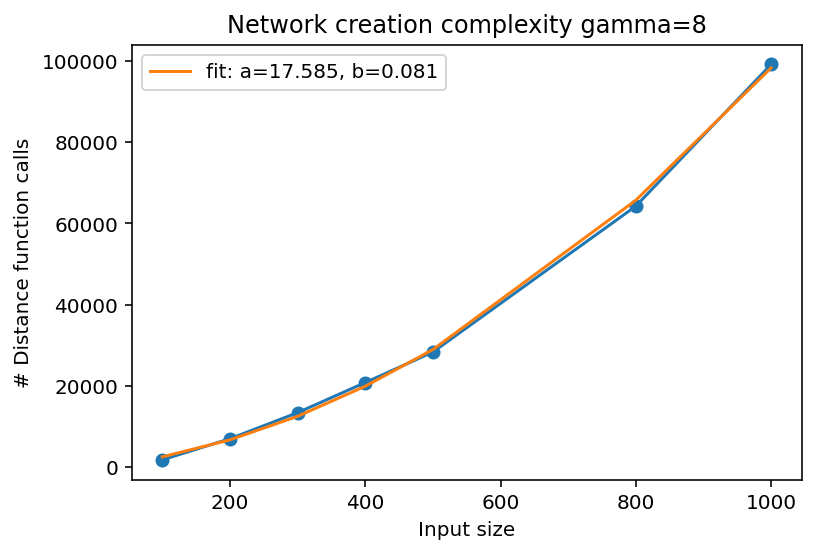

In [391]:

plt.plot(cpx.ops, '-o')
plt.plot(cpx.index, func(cpx.index, *popt), label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

plt.legend()
plt.xlabel('Input size')
plt.ylabel('# Distance function calls');
plt.title(f"Network creation complexity {gamma=}")

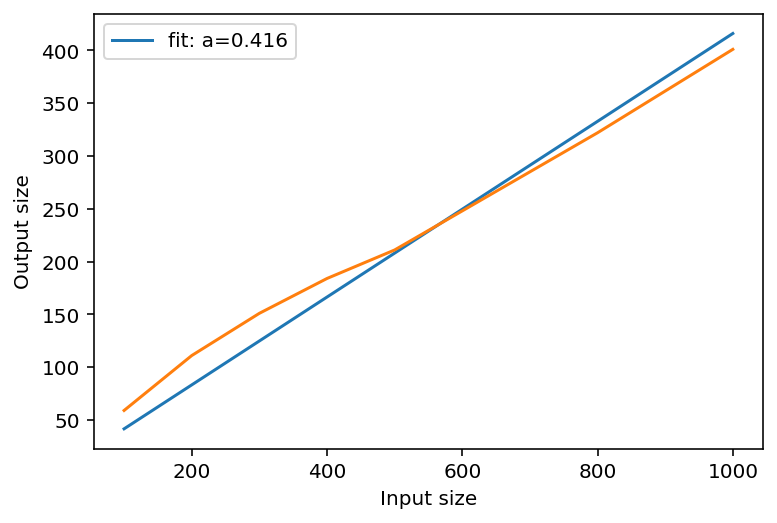

In [390]:
cpopt, cpcov = curve_fit(compression, cpx.index, cpx.net_size)

plt.plot(cpx.index, compression(cpx.index, *cpopt), label='fit: a=%5.3f' % tuple(cpopt))
plt.legend()
plt.plot(cpx.index, cpx.net_size)
plt.xlabel('Input size')
plt.ylabel('Output size');

In [393]:
rdf.loc[8]

one_shot_ops             58714
hierarchical_ops        108005
one_shot_anchors           321
hierarchical_anchors       321
Name: 8, dtype: int64

In [396]:
num_parts = 8
part_size = 100

input_size = compression(part_size, a=0.416) * num_parts
int(func(input_size, *popt))

14786

In [406]:
int(4*func(2*compression(part_size, a=0.41), *popt)  + 2*func(2*compression(part_size, a=0.41), *popt) + compression(2*compression(part_size, a=0.41), a=0.41))

11939

### Notes
1. could be that the complexity of merging/network creation does not only depend on the size of the input but also on the input properties.
So that we are not interessted in o(size), but rather O(size)-worst case complexity
1. compression is mostly done in the network creation phase and not in the network merging(?) 
-this could depend on the input data again (e.g. for lots of small partitions there will be compression through merging)


In [407]:
# how much compression is done by merging
part_size = 100
num_parts = 4
gamma = 8

parts = get_part_indexes(afs, num_parts, part_size)
vnets = [create_voting_net(gamma=gamma, apns=part, distance=lambda x,y: adf(x,y, afs), classifier=lambda x: lcl(x, labs)) for part in parts]

In [422]:
compression = sum([len(v.keys()) for v in vnets])/400
print(f"Network creation preserves {100.0*compression:0.4}% of input points")

Network creation preserves 54.75% of input points


In [412]:
ons = merge_voting_nets_new(nets=vnets, distance=lambda x,y: mydistance(x,y, afs), gamma=gamma)

In [421]:
merging_compression = len(ons.keys())/sum([len(v.keys()) for v in vnets])
print(f"Merged network preserves {100.0*merging_compression:0.4}% of input anchors")

Merged network preserves 83.11% of input anchors
